<a href="https://colab.research.google.com/github/Medianto09/Sentimen-Analisis-Pilpres-2019/blob/main/Sentiment_Analysis_Pilpres_2019.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Sentiment Analysis Indonesia Presidential Election 2019

Background:
> Twitter became a large forum for public discussion during the 2019 presidential election because there were around 5.7 million tweets per day related to the 2019 presidential election. This relatively large amount of data can be used for various analyses, one of which is sentiment analysis.

> Tweet sentiment analysis is important for understanding public opinion towards candidates and related issues. This can help campaign teams, media, researchers and the public. Analyzing sentiment can reveal issues highlighted by the public, perceptions of candidates, support, and the impact of misinformation.

* Objectives ;
> Developing machine learning and deep learning models to classify three sentiments (positive, neutral and negative) from tweets related to the 2019 presidential election in Indonesia.

* Scope & Limitations
> Uses tweet data along with sentiment labels that have been provided & cannot be changed

> The models used are limited to Random Forest Classifier (machine learning) and LSTM (deep learning)

# Prepare Library

In [ ]:
!pip install emoji
!pip install nltk


import pandas as pd
import nltk
import emoji
import seaborn as sns
import os
import matplotlib.pyplot as plt
import numpy as np

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, Dropout

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.metrics import accuracy_score, classification_report
nltk.download('stopwords')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score


# Define stopwords for Indonesian language

stop_words = set('indonesian')  # Tentukan bahasa



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Load & Understand Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
pd.set_option('display.max_colwidth', 25)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = os.getcwd()
project_path = '/content/drive/MyDrive/Project Sentiment Analysis Pilpres 2019'
full_project_path = os.path.join(path, project_path)
dataset_name = 'tweet.csv'

data = pd.read_csv(os.path.join(full_project_path, dataset_name), encoding='utf-8')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1815 entries, 0 to 1814
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  1815 non-null   int64 
 1   sentimen    1815 non-null   object
 2   tweet       1815 non-null   object
dtypes: int64(1), object(2)
memory usage: 42.7+ KB


## summary load & understand data set

*   Data berjumlah 1.815
*   Terdapat 3 label data
*   Label Sentimen sebagai y atau yang akan di prediksi
*   Label Tweet sebagai x (variabel)

Hal yang perlu menjadi perhatian
*   Data yang ada terdapat column yang integer sehingga perlu ditangani atau drop



# Data Inspection

## Menangani integer (Unnamed : 0) dengan menghapus kolom

In [ ]:
# karena data terdapat 1 kolom integer ('Unnamed: 0') maka drop kolom integer
data.drop('Unnamed: 0', axis=1, inplace=True)
data.head()

,sentimen,tweet
0,negatif,Kata @prabowo Indones...
1,netral,"Batuan Langka, Tasbih..."
2,netral,"Di era Jokowi, ekonom..."
3,positif,Bagi Sumatera Selatan...
4,negatif,Negara kita ngutang b...


## mengecek nilai null pada data

In [ ]:
# check nilai null
data.isna().sum()/len(data)

sentimen    0.0
tweet       0.0
dtype: float64

## mengecek proporsi data pada setiap label

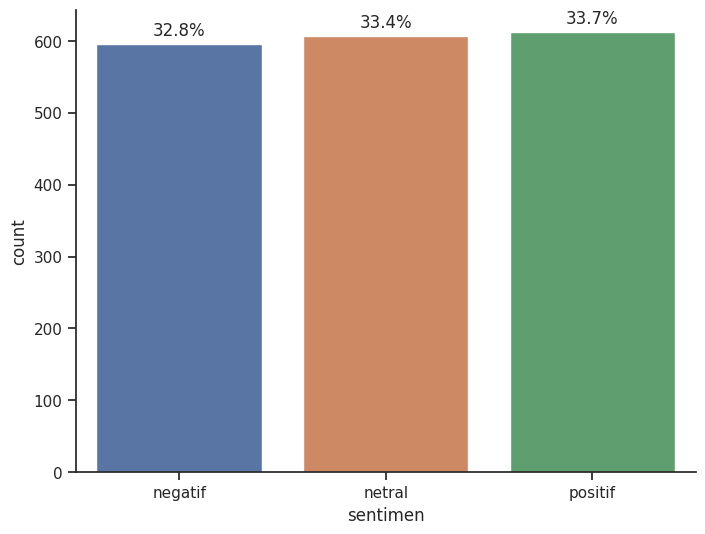

In [ ]:
# Cek proporsi label pada data
plt.figure(figsize=(8, 6), dpi=100)
ax = sns.countplot(data=data, x='sentimen', hue='sentimen')
total = float(len(data))  # total number of data points

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height/total:.1%}', (p.get_x() + p.get_width() / 2., height), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

## Summary Data Inspection
*   Data yang ada tidak ada Null
*   Data proposional pada setiap labelnya

data yang ada cukup proposional atau seimbang sehingga tidak diperlukan langkah oversampling atau undersampling untuk menghindari bias dan overfitting

In [ ]:
# cek duplikasi data
print('Number of rows before duplicates data dropped: ', len(data))
print('Number of rows after duplicates data dropped: ',len(data.drop_duplicates()))
print('Number of duplicated rows: ' , len(data) - len(data.drop_duplicates()))

Number of rows before duplicates data dropped:  1815
Number of rows after duplicates data dropped:  1815
Number of duplicated rows:  0


tidak ada data duplication pada data set

# Data Preprocessing

In [ ]:
# mempersiapkan tampilan untuk hasil data preproses
def random_tweet(before, after, low=0, high=10, length=len(data)):
  for i in np.random.randint(low, length, high):
    print("------------"*100)
    print(f'index {i}')
    print('before: ', before.loc[i])
    print('after: ', after.loc[i])

## Melakukan data preprocessing (EDA) sebelum dilakukan train

Proses yang dilakukan

*   Merubah tweet menjadi huruf kecil
*   Merubah emoticon / emoji menjadi kata yang bermakna
*   Menghapus tanda baca & karakter khusus
*   Menghapus #, username , @, dan URL
*   Mengganti angka 01 dan 02 menjadi kata paslon masing masing, dan menghapus angka selain 01 dan 02
*   Menghapus stopwords







In [ ]:
# Mempersiapkan kolom 'tweet_asli' agar bisa ditampilkan perbandingan
data['tweet_asli'] = data['tweet'].copy()

# Mengubah semua teks menjadi huruf kecil
data['tweet'] = data['tweet'].str.lower()

# Membuat dictionary untuk emoticon dan kata bermakna
emoticon_dict = {
    ':)': 'senang',
    ':(': 'sedih',
    ':D': 'tertawa',
    ':P': 'menjulurkan lidah',
    ':O': 'terkejut',
    ':|': 'bingung',}

# Mengubah kata emoticon pada kolom tweet menjadi kata bermakna
for i in range(len(data)):
    for emoticon, meaning in emoticon_dict.items():
      data.at[i, 'tweet'] = data.at[i, 'tweet'].replace(emoticon, meaning)

# Mengubah kata emoji pada kolom tweet menjadi kata bermakna bahasa Indonesia
data['tweet'] = data['tweet'].apply(lambda x: emoji.demojize(x))

# Menghapus tanda baca dan karakter spesial
data['tweet'] = data['tweet'].str.replace('[^\w\s]', '', regex=True)

# Menghapus hashtag
data['tweet'] = data['tweet'].str.replace('#\w+', '', regex=True)

# Menghapus username dan @
data['tweet'] = data['tweet'].str.replace('@\w+', '', regex=True)

# Menghapus URL
data['tweet'] = data['tweet'].str.replace('https?://\S+|www.\S+','', regex=True)
data['tweet'] = data['tweet'].str.split().str.join(' ')

# Mengubah kolom tweet dengan angka 01 dan 02 menjadi text
data['tweet'] = data['tweet'].replace('01', 'Prabowo-Sandi')
data['tweet'] = data['tweet'].replace('02', 'Jokowi-Ma\'ruf')
data['tweet'] = data['tweet'].str.replace('_', '', regex=False)

# Menghapus angka
data['tweet'] = data['tweet'].str.replace('\d+', '')

# Menghapus kata-kata yang tidak penting (stopwords)
stop_words = set(stopwords.words('indonesian'))
data['tweet'] = data['tweet'].str.split().str.join(' ')
data['tweet'] = data['tweet'].str.split().apply(lambda x: ' '.join([word for word in x if word not in stop_words]))




<ipython-input-33-00e03fc2cc2b>:43: FutureWarning: The default value of regex will change from True to False in a future version.
  data['tweet'] = data['tweet'].str.replace('\d+', '')


## Text Normalization

In [ ]:
#import nltk
#nltk.download('wordnet')
#from nltk.stem import WordNetLemmatizer

# Create a WordNetLemmatizer object
#lemmatizer = WordNetLemmatizer()

# Function to lemmatize tweets
#def lemmatize_tweet(text):
#  """Lemmatizes the words in a tweet."""
#  lemmatized_words = []
#  for word in text.split():
#    lemmatized_words.append(lemmatizer.lemmatize(word))
#  return ' '.join(lemmatized_words)

# Apply lemmatization to the 'tweet' column
#data['tweet'] = data['tweet'].apply(lemmatize_tweet)

#Apply lemmatization to the 'tweet' column
#data['lemmatized_tweet'] = data['tweet'].apply(lemmatize_tweet)

# Calculate the frequency of lemmatized words
#word_counts = data['lemmatized_tweet'].str.split().explode().value_counts()

#print(word_counts.head())

In [ ]:
# Stemming tweet
ps = PorterStemmer()
data['tweet'] = data['tweet'].str.split().apply(lambda x: ' '.join([ps.stem(word) for word in x]))

# Menampilkan data perbandingan tweet sebelum dan sesudah preprocess & stemm
random_tweet(data['tweet_asli'], data['tweet'])

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Summary Text Processing & Text Normalization

*   Semua data terjadi perubahan dari text preprocessing
*   Meskipun telah dicoba dengan Lematisasi dan Stemming, Stemming menjadi pilihan dengan beberapa alasan pada pilpress banyak sekali kata yang mungkin masih belum terkoreksi dengan baik
> stemming dapat membantu normalisasi kata yang belum terkoreksi pada text preprocessing
> Stemming baik untuk analisis frekuensi kata, kategorisasi teks kasar, dan identifikasi topik umum.
> Keterbatasan hardware juga pemilihan stemming



# Classical Model (Random Forest Classifier)

## Membagi data (Data Split)

In [ ]:
# Data Split
X_train, X_test, y_train, y_test = train_test_split(data['tweet'], data['sentimen'], test_size=0.2, random_state=42)


## Vektorisasi Data tweet

In [ ]:
# Vectorize
stop_words = list(stopwords.words('indonesian'))  # Convert set to list
vectorizer = TfidfVectorizer(stop_words='english')
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)


## Model & Train Model

In [ ]:
# Proses Train Model Random Forest Classifier
model = RandomForestClassifier(n_estimators=100)
model.fit(X_train, y_train)


RandomForestClassifier()

## Menampilkan hasil (precision, recall, f1-score)

In [ ]:
# Menampilkan hasil X_Test
y_pred = model.predict(X_test)
accuracytest = accuracy_score(y_test, y_pred)
print('Accuracytest:', accuracytest)
print(classification_report(y_test, y_pred))


Accuracytest: 0.5785123966942148
              precision    recall  f1-score   support

     negatif       0.58      0.63      0.60       115
      netral       0.53      0.67      0.59       118
     positif       0.66      0.45      0.54       130

    accuracy                           0.58       363
   macro avg       0.59      0.58      0.58       363
weighted avg       0.59      0.58      0.58       363



In [ ]:
# Menampilkan hasil X_train
y_pred = model.predict(X_train)
accuracytrain = accuracy_score(y_train, y_pred)
print('Accuracytrain:', accuracytrain)
print(classification_report(y_train, y_pred))

Accuracytrain: 0.9979338842975206
              precision    recall  f1-score   support

     negatif       1.00      1.00      1.00       481
      netral       1.00      1.00      1.00       489
     positif       1.00      1.00      1.00       482

    accuracy                           1.00      1452
   macro avg       1.00      1.00      1.00      1452
weighted avg       1.00      1.00      1.00      1452



## Hasil Confusion Matriks

In [ ]:
# Menampilkan Confusion Matriks model Random Classifier
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_test)
# Calculate the confusion matrix
confusion_matrix = confusion_matrix(y_test, y_pred)

# Print the confusion matrix in a user-friendly format (optional)
print("Confusion Matrix:")
print(pd.DataFrame(confusion_matrix, columns=y_test.unique(), index=y_test.unique()))

Confusion Matrix:
         negatif  positif  netral
negatif       72       31      12
positif       21       79      18
netral        31       40      59


## Mencoba hasil prediksi model dengan tweet baru

In [ ]:
# mencoba model dengan tweet baru
tweet = 'Ekonomi semakin maju di kepemimpinan Jokowi.'
tweet_vector = vectorizer.transform([tweet])
prediction = model.predict(tweet_vector)
print('Sentimen:', prediction[0])


Sentimen: positif


## Summary Classical Model
eksperimen dengan classical model mendapatkan

*   Hasil Accuracy Train 0.99 menunjukan overtrain, dengan beberapa kali percobaaan masih terjadi hal yang sama
*   Hasil Accuracy Test 0.58 artinya masih kurang baik, namun hasil dari prediksi sudah dapat mewakili apabila tujuan dari eksperimen ini lebih kepada melihat kemungkinan arah tweet secara sederhana dengan keterbatasan hardware dan jumlah data
*   Hasil Confusion Matriks menunjukan bahwa performa cukup mewakili nilai sentimen dari masing masing tweet




# Neural Model (LSTM)

## Data Split

In [ ]:
# Membagi data
X_train = data['tweet'].iloc[:int(0.8*len(data))]
y_train = data['sentimen'].iloc[:int(0.8*len(data))]
X_test = data['tweet'].iloc[int(0.8*len(data)):]
y_test = data['sentimen'].iloc[int(0.8*len(data)):]

## Tokenize Data

In [ ]:
# Tokenisasi Data yang ada
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

# Mempersiapkan sequencing data
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=200)
X_test = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=200)


## Membangun Model

In [ ]:
# Membangun model
model = Sequential()
model.add(Embedding(10000, 128, input_length=200))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

# Encoding Data Sentimen
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Menampilkan seluruh model
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 128)          1280000   
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1411713 (5.39 MB)
Trainable params: 1411713 (5.39 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Train Model menggunakan LSTM

In [ ]:
# Proses Train Model LSTM
model.fit(X_train, y_train, epochs=10)


Epoch 1/10
46/46 [==============================] - 44s 736ms/step - loss: 0.0824 - accuracy: 0.3271
Epoch 2/10
46/46 [==============================] - 29s 615ms/step - loss: -0.0700 - accuracy: 0.3285
Epoch 3/10
46/46 [==============================] - 19s 405ms/step - loss: -0.2504 - accuracy: 0.3285
Epoch 4/10
46/46 [==============================] - 17s 368ms/step - loss: -1.5685 - accuracy: 0.3554
Epoch 5/10
46/46 [==============================] - 17s 375ms/step - loss: -5.0037 - accuracy: 0.5041
Epoch 6/10
46/46 [==============================] - 20s 427ms/step - loss: -8.4871 - accuracy: 0.5785
Epoch 7/10
46/46 [==============================] - 17s 375ms/step - loss: -11.5835 - accuracy: 0.6129
Epoch 8/10
46/46 [==============================] - 17s 373ms/step - loss: -14.1547 - accuracy: 0.6191
Epoch 9/10
46/46 [==============================] - 19s 415ms/step - loss: -15.8192 - accuracy: 0.6191
Epoch 10/10
46/46 [==============================] - 20s 420ms/step - loss: -18.

## Evaluasi Model

In [ ]:
# Evaluasi model
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: -8.33018684387207
Test accuracy: 0.45179063081741333


## Mencoba hasil prediksi model dengan tweet yang baru

In [ ]:
# Memprediksi model dengan tweet baru
new_tweet = 'Ekonomi semakin maju di kepemimpinan Jokowi.'
new_tweet = new_tweet.lower()  # Convert to lowercase
new_tweet = new_tweet.replace('[^a-zA-Z0-9 ]', ' ')  # Remove special characters except spaces
new_tweet = tokenizer.texts_to_sequences([new_tweet])
new_tweet = pad_sequences(new_tweet, maxlen=200)

prediction = model.predict(new_tweet)
predicted_class_index = np.argmax(prediction[0])

# Menampilkan hasil prediksi
if predicted_class_index == 0:
    print('Prediction:', 'positif')
elif predicted_class_index == 1:
    print('Prediction:', 'negatif')
else:
    print('Prediction:', 'netral')



1/1 [==============================] - 1s 518ms/step
Prediction: positif


## Summary LSTM
Pada eksperimen dengan LSTM, dengan dataset yang ada menghasilkan


*   Test Loss sebesar -10 yang artinya perlu ada tindak lanjut terkait dengan analisas loss
*   Test Accuracy 0.46 yang artinya masih model masih kurang baik
*   Meskipun hasil masih kurang baik namum prediction masih menunjukan hasil yang sama untuk tweet yang sama pada eksperimen random forest





# Summary of this Project
Dari dataset yang ada dengan dibatasi pada model Random Forest dan LSTM dapat disimpulkan bahwa hasil Random Forest lebih baik dari LSTM, hal ini muncul karena

* Pada eksperimen dengan LSTM,
** dengan data yang ada dirasa kurang optimal untuk belajar dengan polay yang kompleks

* Pada eksperimen dengan Randomforest,
** Lebih efisien dan efektif pada data yang kecil sehingga mampu mengklasifikasi data dengan baik



# Future Improvement


*   Keterbatasan data yang perlu menjadi pehatian utama, sehingga perlu tambahan data yang lebih banyak lagi untuk meningkatkan performa model
*   Keakurasian data label sentimen yang ada, hasil analisa dengan menggunakan Vader (diluar dari proses ini) menunjukan ada kemungkinan terjadi kesalahan lebeling sentimen dari tweet
* Perlu dilakukan percobaan dengan model dan hyperparameter yang lainnya untuk melihat hasil yang baik

